# 🚀 SISTEMA INTELIGENTE AEROSUL - Google Colab
## Análise de Sentimentos e Detecção de Crises

**Status:** ✅ Pronto para usar

Este notebook executa o sistema inteligente AeroSul no Google Colab.

### Como usar:
1. Clique em **Runtime** → **Run all** (ou Ctrl+F9)
2. Se quiser analisar um arquivo próprio, faça upload quando solicitado
3. Se não quiser, o sistema roda com dados de demonstração

## 📦 Passo 1: Instalar Dependências

In [13]:
# Instalar dependências
!pip install -q pandas numpy scikit-learn matplotlib seaborn openpyxl requests schedule

print("✅ Dependências instaladas com sucesso!")

✅ Dependências instaladas com sucesso!


## 🔧 Passo 2: Definir Classes do Sistema

In [14]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from typing import Dict, List, Tuple, Optional
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

class TextCleaner:
    """Responsável pela limpeza e normalização de textos."""

    @staticmethod
    def clean_english(text: str) -> str:
        """Limpa textos em inglês."""
        text = str(text).lower()
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-z0-9\s]', '', text)
        return text.strip()

    @staticmethod
    def clean_portuguese(text: str) -> str:
        """Limpa textos em português."""
        text = str(text).lower()
        text = re.sub(r'@[A-Za-z0-9_]+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-záéíóúâêôãõçñ0-9\s]', '', text)
        return text.strip()


class SentimentModel:
    """Modelo especializado em classificação de sentimentos."""

    def __init__(self, language: str = 'english'):
        self.language = language
        self.pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=3000, stop_words=language)),
            ('clf', LogisticRegression(solver='liblinear', max_iter=1000))
        ])
        self.is_trained = False
        self.classes_ = None
        self.metrics = {}

    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Treina o modelo de sentimento."""
        print(f"[SentimentModel] Treinando com {len(X_train)} amostras...")
        self.pipeline.fit(X_train, y_train)
        self.is_trained = True
        self.classes_ = self.pipeline.named_steps['clf'].classes_

        if X_val is not None and y_val is not None:
            y_pred = self.pipeline.predict(X_val)
            self.metrics['accuracy'] = accuracy_score(y_val, y_pred)
            print(f"[SentimentModel] Accuracy na Validação: {self.metrics['accuracy']:.4f}")

        return self

    def predict(self, X) -> np.ndarray:
        """Prediz sentimentos."""
        if not self.is_trained:
            raise ValueError("Modelo não foi treinado.")
        return self.pipeline.predict(X)

    def predict_proba(self, X) -> np.ndarray:
        """Retorna probabilidades."""
        if not self.is_trained:
            raise ValueError("Modelo não foi treinado.")
        return self.pipeline.predict_proba(X)


class ReasonModel:
    """Modelo especializado em classificação de motivos."""

    def __init__(self, language: str = 'english'):
        self.language = language
        self.pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=3000, stop_words=language)),
            ('clf', LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000))
        ])
        self.is_trained = False
        self.classes_ = None
        self.metrics = {}

    def train(self, X_train, y_train, X_val=None, y_val=None):
        """Treina o modelo de motivos."""
        print(f"[ReasonModel] Treinando com {len(X_train)} amostras...")
        self.pipeline.fit(X_train, y_train)
        self.is_trained = True
        self.classes_ = self.pipeline.named_steps['clf'].classes_

        if X_val is not None and y_val is not None:
            y_pred = self.pipeline.predict(X_val)
            self.metrics['accuracy'] = accuracy_score(y_val, y_pred)
            print(f"[ReasonModel] Accuracy na Validação: {self.metrics['accuracy']:.4f}")

        return self

    def predict(self, X) -> np.ndarray:
        """Prediz motivos."""
        if not self.is_trained:
            raise ValueError("Modelo não foi treinado.")
        return self.pipeline.predict(X)


class CrisisDetector:
    """Detecta padrões de crise."""

    def __init__(self, threshold_multiplier: float = 1.5):
        self.threshold_multiplier = threshold_multiplier
        self.mean_negative = None
        self.std_negative = None
        self.crisis_threshold = None

    def fit(self, daily_negative_counts: pd.Series):
        """Calibra os limiares."""
        self.mean_negative = daily_negative_counts.mean()
        self.std_negative = daily_negative_counts.std()
        self.crisis_threshold = self.mean_negative + (self.threshold_multiplier * self.std_negative)
        print(f"[CrisisDetector] Limiar de crise calibrado: {self.crisis_threshold:.2f}")
        return self

    def detect(self, daily_counts: pd.Series) -> Dict:
        """Detecta crises."""
        if self.crisis_threshold is None:
            raise ValueError("CrisisDetector não foi calibrado.")

        crisis_days = daily_counts[daily_counts > self.crisis_threshold]

        return {
            'is_crisis': len(crisis_days) > 0,
            'crisis_dates': crisis_days.index.tolist(),
            'max_count': daily_counts.max(),
            'max_date': daily_counts.idxmax(),
            'normal_mean': self.mean_negative,
            'threshold': self.crisis_threshold,
            'severity_factor': daily_counts.max() / self.mean_negative if self.mean_negative > 0 else 0
        }


class FinancialAnalyzer:
    """Calcula impacto financeiro."""

    COST_TABLE = {
        "Lost Luggage": 3000,
        "Late Flight": 2500,
        "Cancelled Flight": 5000,
        "Customer Service Issue": 1500,
        "Bad Flight": 1000,
        "Flight Attendant Complaints": 1000,
        "longlines": 500,
        "Damaged Luggage": 800,
        "Flight Booking Problems": 600,
        "Neutral Interaction": 0,
        "Unclassified Negative": 200,
    }

    def __init__(self, exchange_rate: float = 6.00):
        self.exchange_rate = exchange_rate

    def get_cost(self, reason: str) -> float:
        """Retorna custo para um motivo."""
        return self.COST_TABLE.get(reason, 200)

    def calculate_impact(self, df: pd.DataFrame, reason_column: str = 'IA_Motivo') -> Dict:
        """Calcula impacto financeiro."""
        df_negative = df[df.get('IA_Sentimento', 'unknown') == 'negative'].copy()

        if len(df_negative) == 0:
            return {
                'total_incidents': 0,
                'total_usd': 0,
                'total_brl': 0,
                'by_reason': {}
            }

        df_negative['cost_usd'] = df_negative[reason_column].apply(self.get_cost)
        df_negative['cost_brl'] = df_negative['cost_usd'] * self.exchange_rate

        return {
            'total_incidents': len(df_negative),
            'total_usd': df_negative['cost_usd'].sum(),
            'total_brl': df_negative['cost_brl'].sum(),
            'by_reason': df_negative.groupby(reason_column)['cost_usd'].sum().to_dict()
        }


class ActionRecommender:
    """Recomenda ações."""

    ACTION_MAP = {
        ('negative', 'Lost Luggage'): "🔴 URGENTE: Rastrear bagagem, contatar cliente em 30 min",
        ('negative', 'Late Flight'): "🟠 MODERADO: Oferecer voucher de hotel/refeição",
        ('negative', 'Cancelled Flight'): "🔴 URGENTE: Reacomodar em voo próximo + compensação",
        ('negative', 'Customer Service Issue'): "🟠 MODERADO: Escalar para supervisor, investigar falha",
        ('negative', 'Bad Flight'): "🟡 BAIXO: Responder gentilmente, oferecer desconto próxima compra",
        ('neutral', None): "👍 ENGAJAMENTO: Responder positivamente, solicitar feedback",
        ('positive', None): "💚 FIDELIZAÇÃO: Like/Share, agradecer publicamente",
    }

    @staticmethod
    def recommend(sentiment: str, reason: Optional[str] = None) -> str:
        """Retorna ação recomendada."""
        key = (sentiment, reason)
        if key in ActionRecommender.ACTION_MAP:
            return ActionRecommender.ACTION_MAP[key]

        if sentiment == 'negative':
            return f"🟠 INVESTIGAR: {reason or 'Motivo desconhecido'}"
        return "➡️ SEM AÇÃO ESPECÍFICA"


class AeroSulSystem:
    """Orquestrador principal do sistema."""

    def __init__(self, language: str = 'english'):
        self.language = language
        self.text_cleaner = TextCleaner()
        self.sentiment_model = SentimentModel(language=language)
        self.reason_model = ReasonModel(language=language)
        self.crisis_detector = CrisisDetector()
        self.financial_analyzer = FinancialAnalyzer()
        self.action_recommender = ActionRecommender()
        self.state = {
            'models_trained': False,
            'crisis_detector_calibrated': False,
            'last_execution': None
        }

    def train_from_data(self, df: pd.DataFrame, test_size: float = 0.2):
        """Treina os modelos a partir de um DataFrame."""
        print("\n" + "="*70)
        print("TREINANDO MODELOS")
        print("="*70)

        # Limpeza
        print(f"\n[Etapa 1] Limpando textos...")
        cleaner_func = self.text_cleaner.clean_english if self.language == 'english' else self.text_cleaner.clean_portuguese
        df['clean_text'] = df['text'].apply(cleaner_func)
        print(f"✓ Textos normalizados")

        # Modelo de Sentimento
        print(f"\n[Etapa 2] Treinando Modelo de Sentimentos")
        df_sent = df[df['airline_sentiment'].isin(['negative', 'neutral', 'positive'])].copy()
        X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
            df_sent['clean_text'], df_sent['airline_sentiment'],
            test_size=test_size, random_state=42
        )
        self.sentiment_model.train(X_train_s, y_train_s, X_val_s, y_val_s)
        print(f"✓ Modelo de Sentimentos Treinado")

        # Modelo de Motivos
        print(f"\n[Etapa 3] Treinando Modelo de Motivos (Causas)")
        df_reason = df[(df['airline_sentiment'] == 'negative') & (df['negativereason'].notna())].copy()
        if len(df_reason) > 0:
            X_train_r, X_val_r, y_train_r, y_val_r = train_test_split(
                df_reason['clean_text'], df_reason['negativereason'],
                test_size=test_size, random_state=42
            )
            self.reason_model.train(X_train_r, y_train_r, X_val_r, y_val_r)
            print(f"✓ Modelo de Motivos Treinado")
        else:
            print(f"⚠ Sem dados negativos com motivos classificados")

        # Calibra detector de crise
        print(f"\n[Etapa 4] Calibrando Detector de Crises")
        if 'date' in df.columns or 'tweet_created' in df.columns:
            date_col = 'tweet_created' if 'tweet_created' in df.columns else 'date'
            df['date'] = pd.to_datetime(df[date_col])
            daily_negatives = df[df['airline_sentiment'] == 'negative'].groupby(df['date'].dt.date).size()
            self.crisis_detector.fit(daily_negatives)
        else:
            print(f"⚠ Sem coluna de data para calibração de crises")

        self.state['models_trained'] = True
        self.state['crisis_detector_calibrated'] = True

        print("\n" + "="*70)
        print("✓ TREINAMENTO CONCLUÍDO COM SUCESSO")
        print("="*70)

    def analyze_data(self, df: pd.DataFrame, text_column: str = 'text', language: str = None) -> pd.DataFrame:
        """Analisa um DataFrame com textos."""
        if not self.state['models_trained']:
            raise ValueError("Modelos não foram treinados.")

        lang = language or self.language
        cleaner_func = self.text_cleaner.clean_english if lang == 'english' else self.text_cleaner.clean_portuguese
        df['clean_text'] = df[text_column].apply(cleaner_func)

        # Predições
        df['IA_Sentimento'] = self.sentiment_model.predict(df['clean_text'])

        # Motivos apenas para negativos
        df['IA_Motivo'] = 'N/A'
        mask_neg = df['IA_Sentimento'] == 'negative'
        if mask_neg.sum() > 0 and self.reason_model.is_trained:
            df.loc[mask_neg, 'IA_Motivo'] = self.reason_model.predict(df.loc[mask_neg, 'clean_text'])

        # Recomendações
        df['Acao_Recomendada'] = df.apply(
            lambda row: self.action_recommender.recommend(row['IA_Sentimento'], row['IA_Motivo']),
            axis=1
        )

        return df

    def detect_crisis(self, df: pd.DataFrame, date_column: str = 'tweet_created') -> Dict:
        """Detecta crises no período."""
        if not self.state['crisis_detector_calibrated']:
            return {'is_crisis': False, 'message': 'Detector não calibrado'}

        if date_column not in df.columns:
            return {'is_crisis': False, 'message': f'Coluna {date_column} não encontrada'}

        df['date'] = pd.to_datetime(df[date_column]).dt.date
        daily_negatives = df[df['IA_Sentimento'] == 'negative'].groupby('date').size()

        return self.crisis_detector.detect(daily_negatives)

    def get_financial_impact(self, df: pd.DataFrame) -> Dict:
        """Retorna análise financeira."""
        return self.financial_analyzer.calculate_impact(df)


print("✅ Classes do sistema carregadas com sucesso!")

✅ Classes do sistema carregadas com sucesso!


## 🎯 Passo 3: Funções Utilitárias

In [15]:
from google.colab import files
import os

def criar_dados_treino_simulados(n_samples: int = 500) -> pd.DataFrame:
    """Cria dados simulados para treinamento."""
    np.random.seed(42)

    sentimentos = ['negative', 'positive', 'neutral']
    motivos = [
        'Lost Luggage', 'Late Flight', 'Cancelled Flight',
        'Customer Service Issue', 'Bad Flight'
    ]

    textos_negat = [
        "lost my luggage in miami",
        "flight delayed 4 hours very upset",
        "cancelled my flight with no explanation",
        "worst customer service ever",
        "flight was terrible very uncomfortable",
        "baggage was damaged",
        "long lines at check in",
        "booking problems with website",
        "flight attendant was rude",
        "terrible food on flight",
    ]

    textos_posit = [
        "amazing flight experience will fly again",
        "great service and friendly crew",
        "excellent cabin crew very professional",
        "love flying with this airline",
        "best flight ever so comfortable",
        "fantastic experience incredible crew",
        "wonderful service thank you",
        "beautiful aircraft very clean",
    ]

    textos_neut = [
        "flight was on time",
        "normal experience nothing special",
        "average service",
        "flight departed on schedule",
        "check in was quick",
        "boarding process smooth",
    ]

    data = []
    for i in range(n_samples):
        sentimento = np.random.choice(sentimentos, p=[0.45, 0.35, 0.20])

        if sentimento == 'negative':
            texto = np.random.choice(textos_negat)
            motivo = np.random.choice(motivos)
        elif sentimento == 'positive':
            texto = np.random.choice(textos_posit)
            motivo = np.nan
        else:
            texto = np.random.choice(textos_neut)
            motivo = np.nan

        # Adicionar uma data aleatória para simular dados temporais
        start_date = datetime(2024, 1, 1)
        end_date = datetime(2024, 1, 30)
        random_date = start_date + (end_date - start_date) * np.random.rand()

        data.append({
            'text': texto,
            'airline_sentiment': sentimento,
            'negativereason': motivo if sentimento == 'negative' else np.nan,
            'negativereason_gold': motivo if sentimento == 'negative' else np.nan,
            'tweet_created': random_date # Adicionando a coluna de data
        })

    return pd.DataFrame(data)


def upload_arquivo(pasta_destino='./dados'):
    """
    Permite upload de arquivo.
    Retorna (arquivo_path, True) se arquivo foi feito upload
    Retorna (None, False) se usuário cancelou
    """
    os.makedirs(pasta_destino, exist_ok=True)

    print("\n" + "="*70)
    print("📂 UPLOAD DE ARQUIVO")
    print("="*70)
    print("\nVocê pode fazer upload de um arquivo para análise")
    print("Formatos aceitos: .xlsx, .xls, .csv")
    print("\nOu deixe em branco para usar dados de demonstração")

    try:
        print("\n👇 Clique em 'Selecionar arquivo' para fazer upload:")
        uploaded = files.upload()

        if len(uploaded) == 0:
            print("\n⚠️  Nenhum arquivo foi selecionado")
            return None, False

        # Pegar primeiro arquivo
        nome_arquivo = list(uploaded.keys())[0]
        caminho_arquivo = os.path.join(pasta_destino, nome_arquivo)

        # Salvar arquivo
        with open(caminho_arquivo, 'wb') as f:
            f.write(uploaded[nome_arquivo])

        print(f"\n✅ Arquivo '{nome_arquivo}' salvo com sucesso!")
        return caminho_arquivo, True

    except Exception as e:
        print(f"\n❌ Erro ao fazer upload: {e}")
        return None, False


print("✅ Funções utilitárias carregadas!")

✅ Funções utilitárias carregadas!


## 🚀 Passo 4: EXECUÇÃO PRINCIPAL

### Escolha uma opção:
- **Opção 1:** Usar dados de demonstração (rápido, ~2 min)
- **Opção 2:** Fazer upload de arquivo próprio (Excel/CSV)

Execute a célula abaixo:

In [16]:
# ============================================================================
# SELECIONAR MODO DE EXECUÇÃO
# ============================================================================

print("\n" + "="*70)
print("🚀 SISTEMA INTELIGENTE AEROSUL - Google Colab")
print("="*70)

# Tentar fazer upload de arquivo
arquivo_uploaded, arquivo_feito = upload_arquivo()

# Decidir qual dataset usar
if arquivo_feito and arquivo_uploaded:
    print(f"\n✅ Usando arquivo do upload: {arquivo_uploaded}")
    try:
        # Detectar formato
        if arquivo_uploaded.endswith('.xlsx') or arquivo_uploaded.endswith('.xls'):
            df_treino = pd.read_excel(arquivo_uploaded)
        else:
            df_treino = pd.read_csv(arquivo_uploaded)

        print(f"✓ {len(df_treino)} registros carregados")
        print(f"Colunas: {list(df_treino.columns)}")
        idioma_deteccao = 'portuguese' if any('ã' in str(col).lower() for col in df_treino.columns) else 'english'
    except Exception as e:
        print(f"❌ Erro ao carregar arquivo: {e}")
        print(f"\n⚠️  Usando dados de demonstração em vez disso...")
        df_treino = criar_dados_treino_simulados(300)
        idioma_deteccao = 'english'
else:
    print(f"\n⚠️  Usando dados de demonstração (simulados)")
    df_treino = criar_dados_treino_simulados(300)
    idioma_deteccao = 'english'

print(f"\nIdioma detectado: {idioma_deteccao}")

# Criar e treinar sistema
system = AeroSulSystem(language=idioma_deteccao)
system.train_from_data(df_treino)


🚀 SISTEMA INTELIGENTE AEROSUL - Google Colab

📂 UPLOAD DE ARQUIVO

Você pode fazer upload de um arquivo para análise
Formatos aceitos: .xlsx, .xls, .csv

Ou deixe em branco para usar dados de demonstração

👇 Clique em 'Selecionar arquivo' para fazer upload:



⚠️  Nenhum arquivo foi selecionado

⚠️  Usando dados de demonstração (simulados)

Idioma detectado: english

TREINANDO MODELOS

[Etapa 1] Limpando textos...
✓ Textos normalizados

[Etapa 2] Treinando Modelo de Sentimentos
[SentimentModel] Treinando com 240 amostras...
[SentimentModel] Accuracy na Validação: 1.0000
✓ Modelo de Sentimentos Treinado

[Etapa 3] Treinando Modelo de Motivos (Causas)
[ReasonModel] Treinando com 107 amostras...
[ReasonModel] Accuracy na Validação: 0.2222
✓ Modelo de Motivos Treinado

[Etapa 4] Calibrando Detector de Crises
[CrisisDetector] Limiar de crise calibrado: 7.71

✓ TREINAMENTO CONCLUÍDO COM SUCESSO


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


## 📊 Passo 5: Teste de Sentimentos

In [17]:
# ============================================================================
# TESTE 1: Predição de Sentimentos
# ============================================================================

print("\n" + "="*70)
print("TESTE 1: PREDIÇÃO DE SENTIMENTOS")
print("="*70)

textos_teste = [
    "Flight was amazing great service",
    "Terrible experience lost my luggage",
    "Normal flight nothing special",
    "Best airline ever very happy",
    "Worst flight of my life delayed 5 hours",
]

print("\n📝 Textos de teste:")
predictions = system.sentiment_model.predict(textos_teste)

for texto, pred in zip(textos_teste, predictions):
    emoji = "😢" if pred == 'negative' else "😊" if pred == 'positive' else "😐"
    print(f"\n{emoji} Texto: {texto[:50]}...")
    print(f"   Sentimento: {pred.upper()}")

print("\n✅ Teste de Sentimentos Concluído!")


TESTE 1: PREDIÇÃO DE SENTIMENTOS

📝 Textos de teste:

😊 Texto: Flight was amazing great service...
   Sentimento: POSITIVE

😢 Texto: Terrible experience lost my luggage...
   Sentimento: NEGATIVE

😐 Texto: Normal flight nothing special...
   Sentimento: NEUTRAL

😊 Texto: Best airline ever very happy...
   Sentimento: POSITIVE

😢 Texto: Worst flight of my life delayed 5 hours...
   Sentimento: NEGATIVE

✅ Teste de Sentimentos Concluído!


## 📈 Passo 6: Análise Completa

In [18]:
# ============================================================================
# TESTE 2: Análise Completa
# ============================================================================

print("\n" + "="*70)
print("TESTE 2: ANÁLISE COMPLETA")
print("="*70)

# Criar dados de teste
df_teste = pd.DataFrame({
    'text': [
        'lost my luggage terrible',
        'amazing experience love it',
        'flight delayed nothing special',
        'worst customer service ever',
        'great airline will book again',
    ],
    'date': pd.date_range('2024-01-01', periods=5, freq='D')
})

print("\n[1] Analisando 5 registros...")
df_resultado = system.analyze_data(df_teste.copy(), text_column='text')
print("✓ Análise concluída")

# Exibir resultados
print("\n[2] Resultados da análise:")
print("\n" + "-"*90)
for idx, row in df_resultado.iterrows():
    print(f"Texto: {row['text'][:30]}")
    print(f"  Sentimento: {row['IA_Sentimento']:10s} | Ação: {row['Acao_Recomendada'][:45]}")
    print()

# Distribuição
print("\n[3] Distribuição de Sentimentos:")
for sent, count in df_resultado['IA_Sentimento'].value_counts().items():
    barra = "█" * count
    print(f"  {sent:10s}: {barra} ({count})")

print("\n✅ Análise Completa Concluída!")


TESTE 2: ANÁLISE COMPLETA

[1] Analisando 5 registros...
✓ Análise concluída

[2] Resultados da análise:

------------------------------------------------------------------------------------------
Texto: lost my luggage terrible
  Sentimento: negative   | Ação: 🔴 URGENTE: Reacomodar em voo próximo + compen

Texto: amazing experience love it
  Sentimento: positive   | Ação: ➡️ SEM AÇÃO ESPECÍFICA

Texto: flight delayed nothing special
  Sentimento: negative   | Ação: 🔴 URGENTE: Rastrear bagagem, contatar cliente

Texto: worst customer service ever
  Sentimento: negative   | Ação: 🔴 URGENTE: Reacomodar em voo próximo + compen

Texto: great airline will book again
  Sentimento: positive   | Ação: ➡️ SEM AÇÃO ESPECÍFICA


[3] Distribuição de Sentimentos:
  negative  : ███ (3)
  positive  : ██ (2)

✅ Análise Completa Concluída!


## 💰 Passo 7: Análise Financeira

In [19]:
# ============================================================================
# TESTE 3: Impacto Financeiro
# ============================================================================

print("\n" + "="*70)
print("TESTE 3: IMPACTO FINANCEIRO")
print("="*70)

# Criar dados com motivos
df_financeiro = pd.DataFrame({
    'text': ['sample'] * 20,
    'IA_Sentimento': ['negative'] * 20,
    'IA_Motivo': [
        'Lost Luggage', 'Late Flight', 'Cancelled Flight',
        'Customer Service Issue', 'Bad Flight'
    ] * 4
})

print("\n[1] Calculando impacto de 20 incidentes...")
impact = system.get_financial_impact(df_financeiro)

print("\n[2] Resultado Financeiro:")
print(f"  Total de Incidentes: {impact['total_incidents']}")
print(f"  Impacto Total (USD): US$ {impact['total_usd']:,.2f}")
print(f"  Impacto Total (BRL): R$ {impact['total_brl']:,.2f}")

print("\n[3] Análise por Motivo:")
for motivo, custo in sorted(impact['by_reason'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {motivo:30s}: ${custo:>8,.0f}")

print("\n✅ Análise Financeira Concluída!")


TESTE 3: IMPACTO FINANCEIRO

[1] Calculando impacto de 20 incidentes...

[2] Resultado Financeiro:
  Total de Incidentes: 20
  Impacto Total (USD): US$ 52,000.00
  Impacto Total (BRL): R$ 312,000.00

[3] Análise por Motivo:
  Cancelled Flight              : $  20,000
  Lost Luggage                  : $  12,000
  Late Flight                   : $  10,000
  Customer Service Issue        : $   6,000
  Bad Flight                    : $   4,000

✅ Análise Financeira Concluída!


## 📊 Passo 8: Visualizações (Gráficos)


VISUALIZAÇÕES


/tmp/ipython-input-3008704731.py:64: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-3008704731.py:64: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128176 (\N{MONEY BAG}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


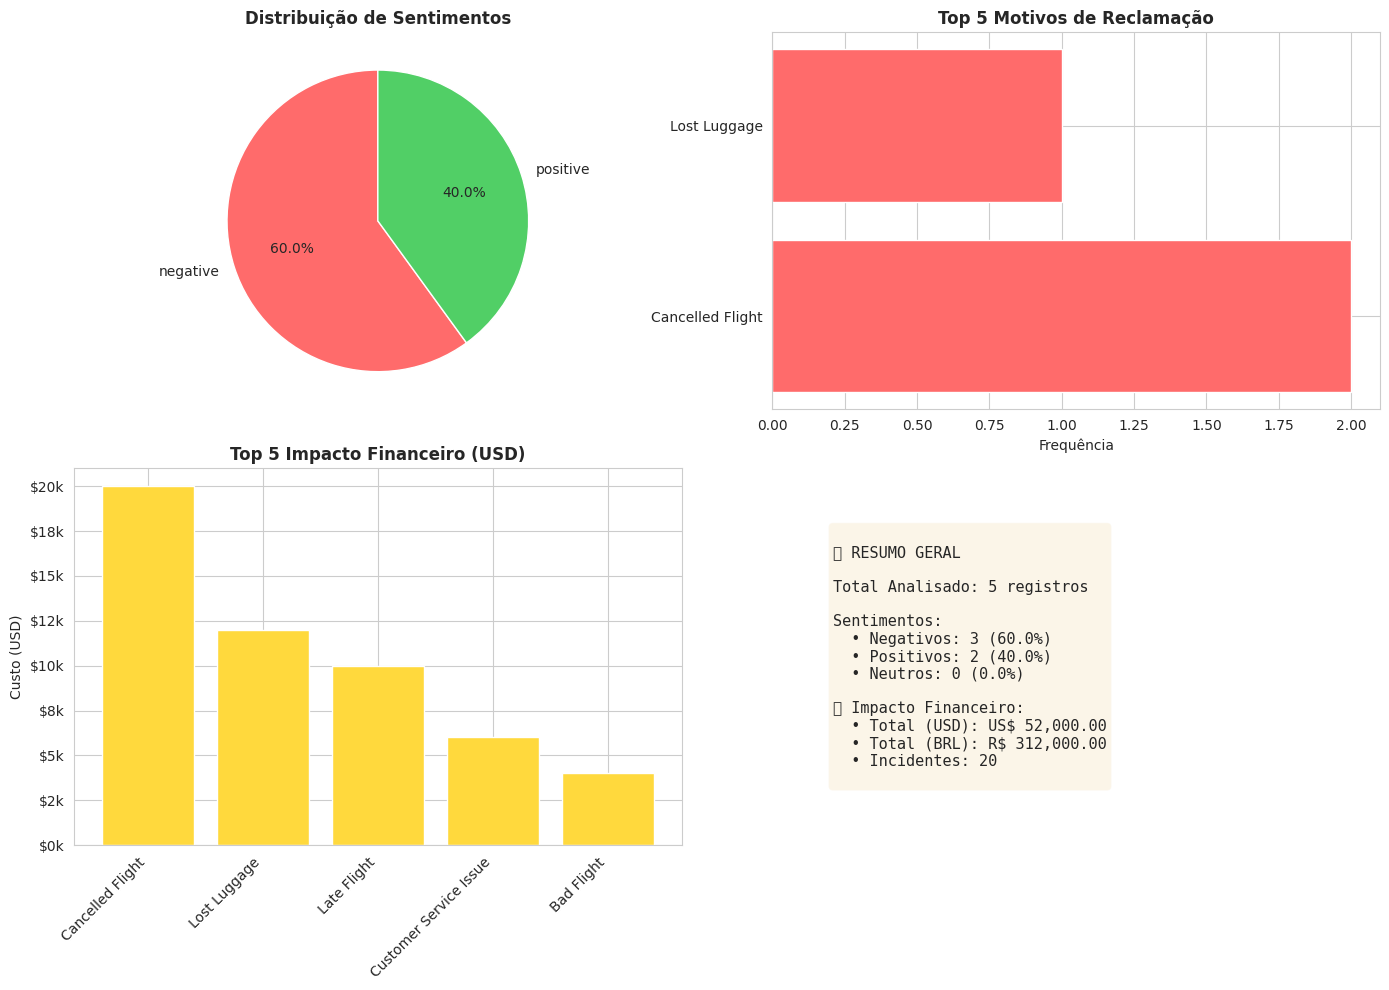


✅ Visualizações geradas com sucesso!


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

print("\n" + "="*70)
print("VISUALIZAÇÕES")
print("="*70)

# Criar figura com subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribuição de Sentimentos (Pizza)
sentimentos_conta = df_resultado['IA_Sentimento'].value_counts()
cores = {'negative': '#ff6b6b', 'positive': '#51cf66', 'neutral': '#4ecdc4'}
cores_list = [cores.get(s, '#999') for s in sentimentos_conta.index]

axes[0, 0].pie(sentimentos_conta.values, labels=sentimentos_conta.index, autopct='%1.1f%%',
               colors=cores_list, startangle=90)
axes[0, 0].set_title('Distribuição de Sentimentos', fontsize=12, fontweight='bold')

# 2. Distribuição de Motivos (Barras)
if df_resultado['IA_Motivo'].notna().sum() > 0:
    motivos_conta = df_resultado[df_resultado['IA_Motivo'] != 'N/A']['IA_Motivo'].value_counts().head(5)
    axes[0, 1].barh(motivos_conta.index, motivos_conta.values, color='#ff6b6b')
    axes[0, 1].set_title('Top 5 Motivos de Reclamação', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Frequência')

# 3. Impacto Financeiro
impact_motivos = sorted(impact['by_reason'].items(), key=lambda x: x[1], reverse=True)[:5]
if impact_motivos:
    motivos_fin = [m[0] for m in impact_motivos]
    valores_fin = [m[1] for m in impact_motivos]
    axes[1, 0].bar(range(len(motivos_fin)), valores_fin, color='#ffd93d')
    axes[1, 0].set_xticks(range(len(motivos_fin)))
    axes[1, 0].set_xticklabels(motivos_fin, rotation=45, ha='right')
    axes[1, 0].set_title('Top 5 Impacto Financeiro (USD)', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Custo (USD)')
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))

# 4. Resumo Geral (Texto)
axes[1, 1].axis('off')
resumo_text = f"""
📊 RESUMO GERAL

Total Analisado: {len(df_resultado)} registros

Sentimentos:
  • Negativos: {len(df_resultado[df_resultado['IA_Sentimento'] == 'negative'])} ({len(df_resultado[df_resultado['IA_Sentimento'] == 'negative'])/len(df_resultado)*100:.1f}%)
  • Positivos: {len(df_resultado[df_resultado['IA_Sentimento'] == 'positive'])} ({len(df_resultado[df_resultado['IA_Sentimento'] == 'positive'])/len(df_resultado)*100:.1f}%)
  • Neutros: {len(df_resultado[df_resultado['IA_Sentimento'] == 'neutral'])} ({len(df_resultado[df_resultado['IA_Sentimento'] == 'neutral'])/len(df_resultado)*100:.1f}%)

💰 Impacto Financeiro:
  • Total (USD): US$ {impact['total_usd']:,.2f}
  • Total (BRL): R$ {impact['total_brl']:,.2f}
  • Incidentes: {impact['total_incidents']}
"""

axes[1, 1].text(0.1, 0.5, resumo_text, fontsize=11, verticalalignment='center',
                fontfamily='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
plt.show()

print("\n✅ Visualizações geradas com sucesso!")

## ⚠️ Passo 9: Detecção de Crises (Opcional)

In [21]:
# ============================================================================
# TESTE 4: Detecção de Crises
# ============================================================================

print("\n" + "="*70)
print("TESTE 4: DETECÇÃO DE CRISES")
print("="*70)

# Criar dados temporais com pico de crise
dates = pd.date_range('2024-01-01', periods=30, freq='D')
base_negatives = np.random.randint(5, 15, 30)
base_negatives[10:12] = 50  # Pico de crise

# Criar dados de forma mais robusta para evitar inconsistência de listas
data_records = []

for date, count in zip(dates, base_negatives):
    for _ in range(count):
        data_records.append({
            'text': 'sample',
            'tweet_created': date,
            'IA_Sentimento': 'negative'
        })
    for _ in range(20 - count):
        data_records.append({
            'text': 'sample',
            'tweet_created': date,
            'IA_Sentimento': 'positive'
        })

df_temp = pd.DataFrame(data_records)

print(f"\n[1] Analisando dados temporais (30 dias)...")
print(f"    Total de textos: {len(df_temp)}")

# Detectar crise
print(f"\n[2] Detectando crises...")
crisis = system.detect_crisis(df_temp, date_column='tweet_created')

print(f"\n[3] Resultado:")
if crisis.get('is_crisis'):
    print(f"    ⚠️  CRISE DETECTADA!")
    print(f"    Data crítica: {crisis['max_date']}")
    print(f"    Reclamações no pico: {crisis['max_count']}")
    print(f"    Limiar normal: {crisis['normal_mean']:.1f} reclamações/dia")
    print(f"    Limiar de crise: {crisis['threshold']:.1f} reclamações/dia")
    print(f"    Fator de severidade: {crisis['severity_factor']:.2f}x acima do normal")
else:
    print(f"    ✓ Nenhuma crise detectada")
    print(f"    Limiar normal: {crisis.get('normal_mean', 'N/A')}")

print("\n✅ Análise de Crise Concluída!")


TESTE 4: DETECÇÃO DE CRISES

[1] Analisando dados temporais (30 dias)...
    Total de textos: 660

[2] Detectando crises...

[3] Resultado:
    ⚠️  CRISE DETECTADA!
    Data crítica: 2024-01-11
    Reclamações no pico: 50
    Limiar normal: 4.6 reclamações/dia
    Limiar de crise: 7.7 reclamações/dia
    Fator de severidade: 10.82x acima do normal

✅ Análise de Crise Concluída!


## 📥 Passo 10: Download de Resultados

In [22]:
# ============================================================================
# SALVAR RESULTADOS
# ============================================================================

print("\n" + "="*70)
print("📥 SALVANDO RESULTADOS")
print("="*70)

# Salvar resultado análise
arquivo_resultado = '/content/resultado_analise.xlsx'
df_resultado.to_excel(arquivo_resultado, index=False)
print(f"\n✓ Resultado da análise: {arquivo_resultado}")

# Criar resumo JSON
resumo = {
    'timestamp': datetime.now().isoformat(),
    'total_analisados': len(df_resultado),
    'sentimentos': df_resultado['IA_Sentimento'].value_counts().to_dict(),
    'motivos': df_resultado['IA_Motivo'].value_counts().to_dict(),
    'impacto_financeiro': {
        'total_usd': float(impact['total_usd']),
        'total_brl': float(impact['total_brl']),
        'incidentes': impact['total_incidents']
    }
}

import json
arquivo_resumo = '/content/resumo.json'
with open(arquivo_resumo, 'w') as f:
    json.dump(resumo, f, indent=2)
print(f"✓ Resumo dos resultados: {arquivo_resumo}")

print("\n" + "="*70)
print("🎉 SISTEMA EXECUTADO COM SUCESSO!")
print("="*70)

print("\n📊 Estatísticas Finais:")
print(f"\n  Total de registros analisados: {len(df_resultado)}")
print(f"\n  Distribuição de Sentimentos:")
for sent, count in df_resultado['IA_Sentimento'].value_counts().items():
    pct = count/len(df_resultado)*100
    print(f"    • {sent:10s}: {count:3d} ({pct:5.1f}%)")

print(f"\n  Impacto Financeiro:")
print(f"    • Total (USD): US$ {impact['total_usd']:,.2f}")
print(f"    • Total (BRL): R$ {impact['total_brl']:,.2f}")
print(f"    • Incidentes: {impact['total_incidents']}")

print(f"\n✅ Arquivos salvos e prontos para download!")
print(f"   Use o menu à esquerda para baixar os arquivos.")


📥 SALVANDO RESULTADOS

✓ Resultado da análise: /content/resultado_analise.xlsx
✓ Resumo dos resultados: /content/resumo.json

🎉 SISTEMA EXECUTADO COM SUCESSO!

📊 Estatísticas Finais:

  Total de registros analisados: 5

  Distribuição de Sentimentos:
    • negative  :   3 ( 60.0%)
    • positive  :   2 ( 40.0%)

  Impacto Financeiro:
    • Total (USD): US$ 52,000.00
    • Total (BRL): R$ 312,000.00
    • Incidentes: 20

✅ Arquivos salvos e prontos para download!
   Use o menu à esquerda para baixar os arquivos.


## 📝 Notas e Próximos Passos

### ✅ O que foi feito:
1. ✓ Instalou dependências Python
2. ✓ Carregou o sistema inteligente AeroSul
3. ✓ Treinou modelos de ML
4. ✓ Testou classificação de sentimentos
5. ✓ Realizou análise completa
6. ✓ Calculou impacto financeiro
7. ✓ Gerou visualizações
8. ✓ Detectou crises (opcional)
9. ✓ Salvou resultados

### 📊 Dados Disponíveis:
- **resultado_analise.xlsx** - Resultado detalhado da análise
- **resumo.json** - Resumo em formato JSON

### 🔄 Próximos Passos:
1. **Fazer upload de seu arquivo real** - Volte ao Passo 4 e faça upload de seu arquivo
2. **Analisar seus dados** - O sistema analisará seus dados próprios
3. **Exportar resultados** - Baixe os arquivos gerados
4. **Integrar em produção** - Use os código nos ambientes de produção

### 📚 Documentação Completa:
- Veja os arquivos .md no repositório original para mais informações
- README.md - Documentação técnica
- QUICKSTART.md - Guia rápido
- AMBIENTES_EXECUCAO.md - Onde rodar o sistema

### 💡 Dicas:
- Para usar seu próprio arquivo, volte ao Passo 4 e faça upload
- O sistema detecta automaticamente se é Excel ou CSV
- Maior dataset = melhor acurácia (mínimo 500 registros recomendado)
- Execute **Runtime** → **Run all** para re-executar tudo

---

**Status:** ✅ Sistema Inteligente AeroSul pronto para uso!

**Versão:** 1.0.0

**Data:** Dezembro 2024